# Proyecto: Visualizaciones en Python — Parte I  
**Alumno:** Rafael Andres Vazquez  
**Archivo:** `ProyectoDSParteI+Vazquez.ipynb`

> **Nota:** Esta entrega utiliza una muestra de 2.000 filas del dataset original (~370k) para cumplir con el criterio de "probar con subconjuntos" y acelerar la ejecución.

## Abstract (250–500 palabras)

Este proyecto corresponde a la primera entrega del análisis exploratorio de datos (EDA) aplicado a un conjunto de datos de anuncios de vehículos usados en Alemania. El dataset original contiene aproximadamente 370.000 registros y 21 variables que describen distintos aspectos de los anuncios publicados en una plataforma en línea. Para esta entrega se trabaja con una muestra de 2.000 observaciones, suficiente para ilustrar patrones relevantes y cumplir con los objetivos del curso con ejecución ágil.

El propósito del análisis es comprender la estructura del mercado de autos usados, identificar variables con mayor influencia en el precio y en la visibilidad del anuncio, y evaluar la calidad de los datos. El dataset incluye información temporal (fechas de rastreo, creación y última visualización del anuncio), atributos técnicos del vehículo (tipo de carrocería, combustible, año de registro, transmisión, kilometraje), variables categóricas asociadas a la marca y al modelo, además de metadatos del anunciante (tipo de vendedor y tipo de oferta), e indicadores de estado como `notRepairedDamage`.

El alcance geográfico está dado por el código postal (`postalCode`), útil para ubicar zonas de mayor actividad; en tanto, el alcance temporal se concentra en marzo–abril de 2016, por lo que los resultados representan ese intervalo específico del mercado. Esta acotación temporal y la naturaleza observacional del dataset motivan una lectura cuidadosa de las conclusiones.

La metodología sigue una secuencia estándar de EDA: (1) configuración reproducible (semillas fijas y versiones), (2) carga parametrizable del dataset con opción de muestreo, (3) diagnóstico de calidad de datos (faltantes, cardinalidad y outliers), (4) glosario automático de variables con tipo de dato, porcentaje de faltantes, cardinalidad y ejemplos, (5) resúmenes estadísticos y (6) visualizaciones univariadas, bivariadas y multivariadas (dispersión 3D o segmentación 2D), cada una con su interpretación conectada a preguntas e hipótesis del dominio.

Los insights esperados incluyen: relación inversa entre precio y kilometraje; asociación positiva entre año de registro y precio (vehículos más recientes tienden a valer más, con excepciones de autos de colección); y diferencias de precio por marca y tipo de combustible. Se prevé la presencia de valores atípicos (precios en cero o extremadamente altos) y posibles inconsistencias de texto en `model` y `name`, por lo que se aplican recortes simples para visualización y se reportan limitaciones.

Entre las restricciones principales se encuentran: sesgo observacional (al basarse en anuncios de una plataforma), período temporal acotado y potenciales duplicados/inconsistencias. Por ello, esta entrega debe considerarse una exploración descriptiva que genera hipótesis y orienta etapas posteriores (limpieza avanzada, normalización de categorías, enriquecimiento de variables y modelado predictivo del precio).

## Configuración e importaciones

In [1]:
import sys, os, random, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

SEED = 42
np.random.seed(SEED); random.seed(SEED)

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

print("Versiones:")
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy:  {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

Versiones:
Python: 3.11.8
NumPy:  1.24.0
Pandas: 1.5.3
Matplotlib: 3.6.3


## Carga del dataset (ruta parametrizable) y muestreo

In [2]:
DATA_PATH = Path("/mnt/data/archive_extracted/autos.csv")
USE_SAMPLE = True
SAMPLE_N = 2000

import pandas as pd

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"No se encontró el archivo: {path}")
    if path.suffix.lower() == ".csv":
        return pd.read_csv(path)
    elif path.suffix.lower() in (".parquet", ".pq"):
        return pd.read_parquet(path)
    else:
        raise ValueError("Formato no soportado. Usa .csv o .parquet")

df_full_head = pd.read_csv(DATA_PATH, nrows=5)
df = pd.read_csv(DATA_PATH, nrows=SAMPLE_N) if USE_SAMPLE else load_dataset(DATA_PATH)

print(f"Dimensiones usadas: {df.shape}  (USE_SAMPLE={USE_SAMPLE}, N={SAMPLE_N})")
df.head()

Dimensiones usadas: (2000, 21)  (USE_SAMPLE=True, N=2000)


,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Diccionario de datos / Glosario (auto-generado)

In [3]:
def data_dictionary(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    total = len(df)
    for col in df.columns:
        s = df[col]
        dtype = s.dtype
        missing = s.isna().sum()
        missing_pct = (missing / total * 100) if total > 0 else 0.0
        nunique = s.nunique(dropna=True)
        example_vals = s.dropna().unique()[:3]
        example_vals = ", ".join(map(str, example_vals))
        rows.append({
            "columna": col,
            "dtype": str(dtype),
            "faltantes": int(missing),
            "%faltantes": round(missing_pct, 2),
            "cardinalidad": int(nunique),
            "ejemplos": example_vals
        })
    dd = pd.DataFrame(rows).sort_values("%faltantes", ascending=False).reset_index(drop=True)
    return dd

dd = data_dictionary(df)
dd.head(20)

,columna,dtype,faltantes,%faltantes,cardinalidad,ejemplos
0,notRepairedDamage,object,400,20.0,2,"ja, nein"
1,vehicleType,object,228,11.4,8,"coupe, suv, kleinwagen"
2,fuelType,object,188,9.4,5,"benzin, diesel, lpg"
3,gearbox,object,118,5.9,2,"manuell, automatik"
4,model,object,104,5.2,190,"golf, grand, fabia"
5,index,int64,0,0.0,2000,"0, 1, 2"
6,kilometer,int64,0,0.0,13,"150000, 125000, 90000"
7,postalCode,int64,0,0.0,1587,"70435, 66954, 90480"
8,nrOfPictures,int64,0,0.0,1,0
9,dateCreated,object,0,0.0,40,"2016-03-24 00:00:00, 2016-03-14 00:00:00, 2016..."


## Preguntas e hipótesis (vinculadas a variables)

1. **¿Cómo varía el `price` según el `kilometer`?**  
*H1:* A mayor kilometraje, menor precio.
2. **¿Existe relación entre `yearOfRegistration` y `price`?**  
*H2:* Vehículos más recientes presentan precios más altos.
3. **¿Qué marcas (`brand`) concentran mayor precio promedio?**  
*H3:* Marcas premium (Audi, BMW, Mercedes) superan a marcas populares.
4. **¿Influye `fuelType` en el precio y el kilometraje?**  
*H4:* Diésel tiende a mostrar mayor kilometraje; la nafta, menor.
5. **¿Impacta `notRepairedDamage` sobre el precio?**  
*H5:* Anuncios con daños no reparados (`ja`) exhiben menor precio medio.

## Calidad de datos y valores perdidos

In [4]:
def missing_table(df: pd.DataFrame) -> pd.DataFrame:
    mt = pd.DataFrame({
        "faltantes": df.isna().sum(),
        "%faltantes": df.isna().mean()*100
    }).sort_values("%faltantes", ascending=False)
    mt.index.name = "columna"
    return mt

mt = missing_table(df)
mt.head(20)

,faltantes,%faltantes
columna,,
notRepairedDamage,400,20.0
vehicleType,228,11.4
fuelType,188,9.4
gearbox,118,5.9
model,104,5.2
index,0,0.0
kilometer,0,0.0
postalCode,0,0.0
nrOfPictures,0,0.0


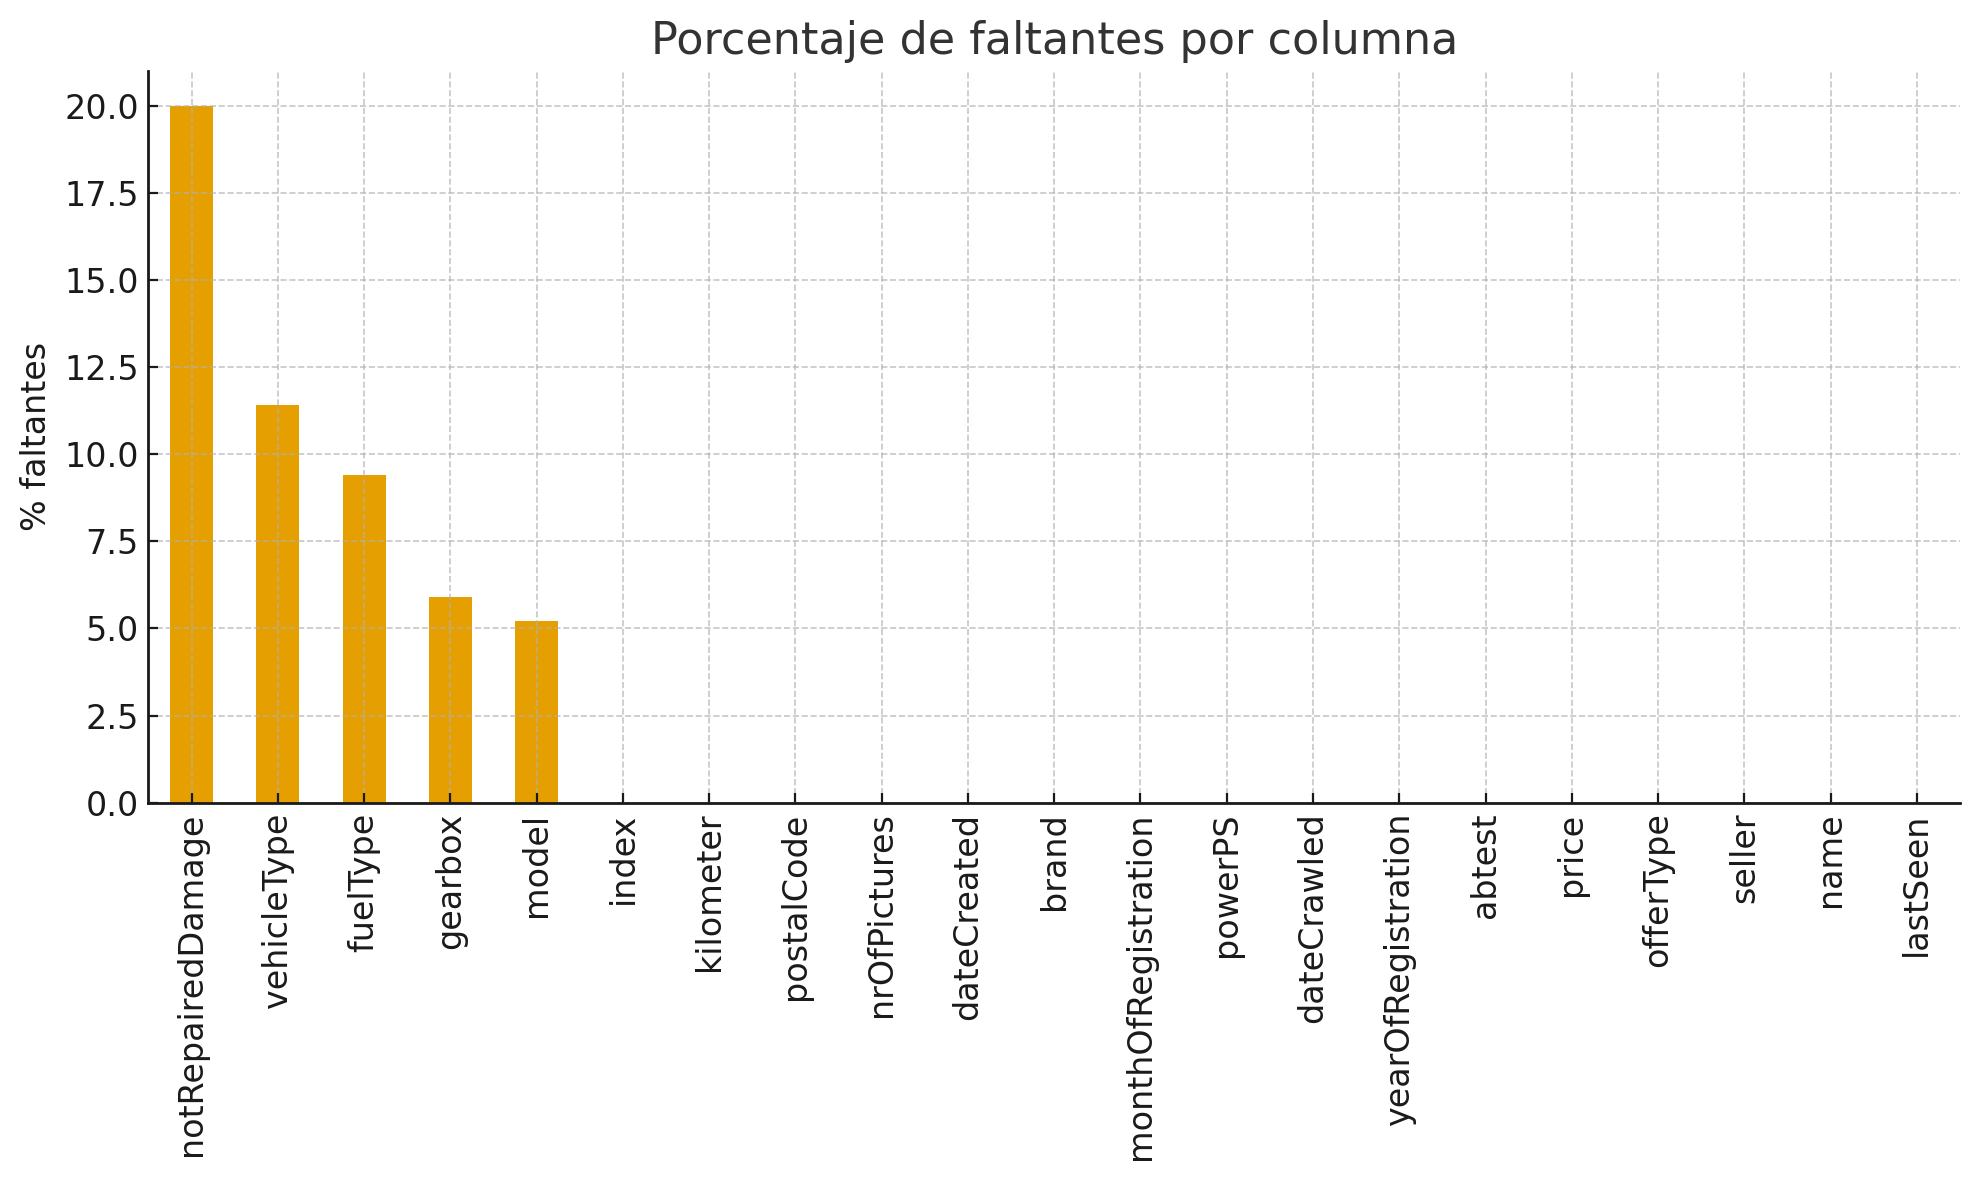

In [5]:
plt.figure()
missing_pct = (df.isna().mean()*100).sort_values(ascending=False)
missing_pct.plot(kind="bar")
plt.ylabel("% faltantes")
plt.title("Porcentaje de faltantes por columna")
plt.tight_layout()
plt.show()

## Resúmenes numéricos

In [6]:
import numpy as np
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc_num = df[num_cols].describe().T if num_cols else pd.DataFrame()
desc_num

,count,mean,std,min,25%,50%,75%,max
index,2000.0,999.5000,577.494589,0.0,499.75,999.5,1499.25,1999.0
price,2000.0,6006.3665,15036.838848,0.0,1200.00,3125.0,7492.25,579000.0
yearOfRegistration,2000.0,2003.1320,21.423913,1111.0,1999.00,2004.0,2008.00,2018.0
powerPS,2000.0,112.3250,76.376810,0.0,73.00,105.0,150.00,1398.0
kilometer,2000.0,124630.0000,40757.437166,5000.0,100000.00,150000.0,150000.00,150000.0
monthOfRegistration,2000.0,5.9390,3.746905,0.0,3.00,6.0,9.00,12.0
nrOfPictures,2000.0,0.0000,0.000000,0.0,0.00,0.0,0.00,0.0
postalCode,2000.0,50814.9530,25892.212915,1067.0,30444.50,50149.0,71095.00,99974.0


In [7]:
if "brand" in df.columns:
    df["brand"].astype("category").value_counts(dropna=False).head(15)

## Visualizaciones univariadas

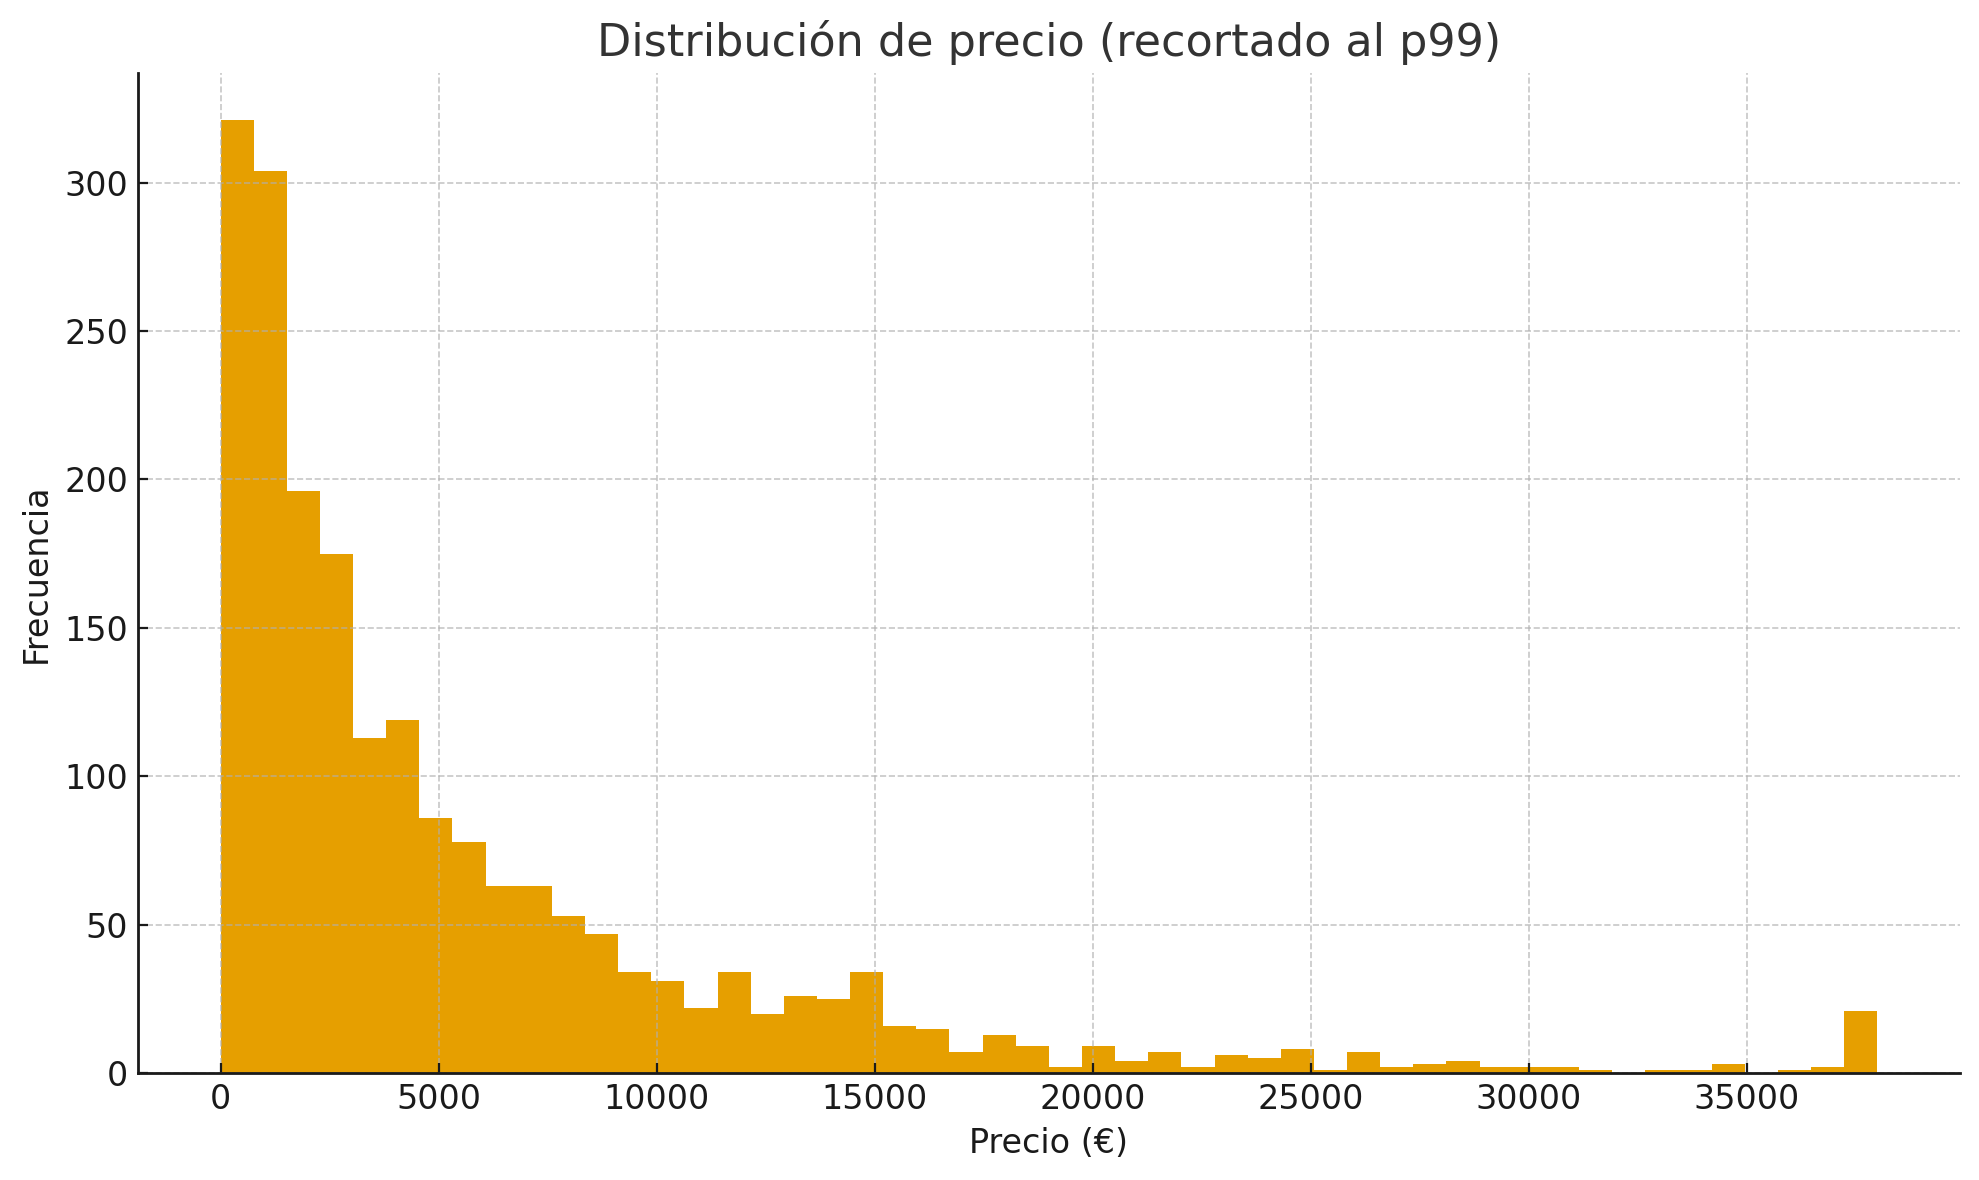

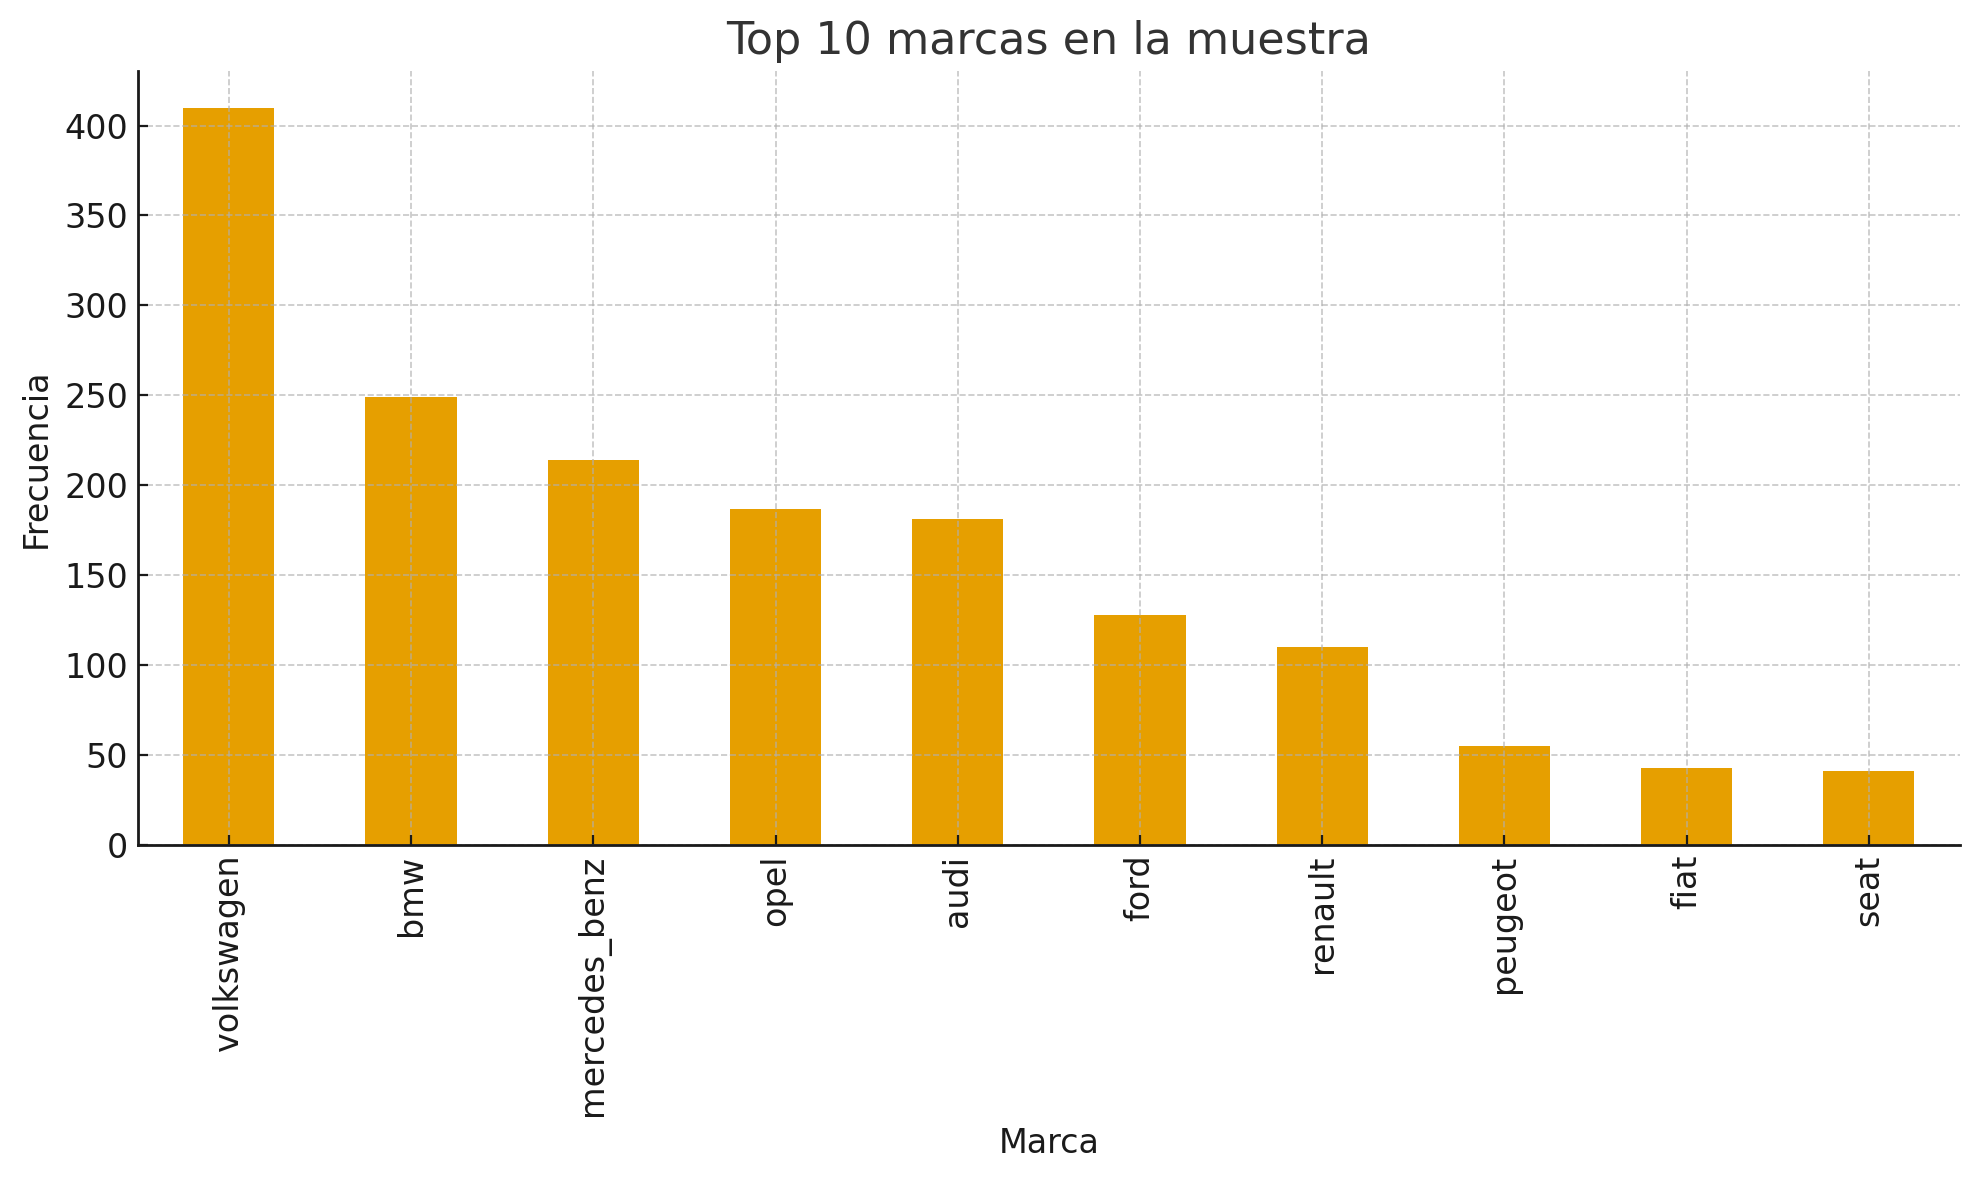

In [8]:
price = df["price"].clip(0, df["price"].quantile(0.99))
plt.figure()
plt.hist(price.dropna(), bins=50)
plt.title("Distribución de precio (recortado al p99)")
plt.xlabel("Precio (€)"); plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

if "brand" in df.columns:
    plt.figure()
    df["brand"].value_counts().head(10).plot(kind="bar")
    plt.title("Top 10 marcas en la muestra")
    plt.xlabel("Marca"); plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

**Interpretación (univariadas):** El precio presenta asimetría positiva y outliers; la distribución por marca muestra concentración en pocas marcas populares.

## Visualizaciones bivariadas

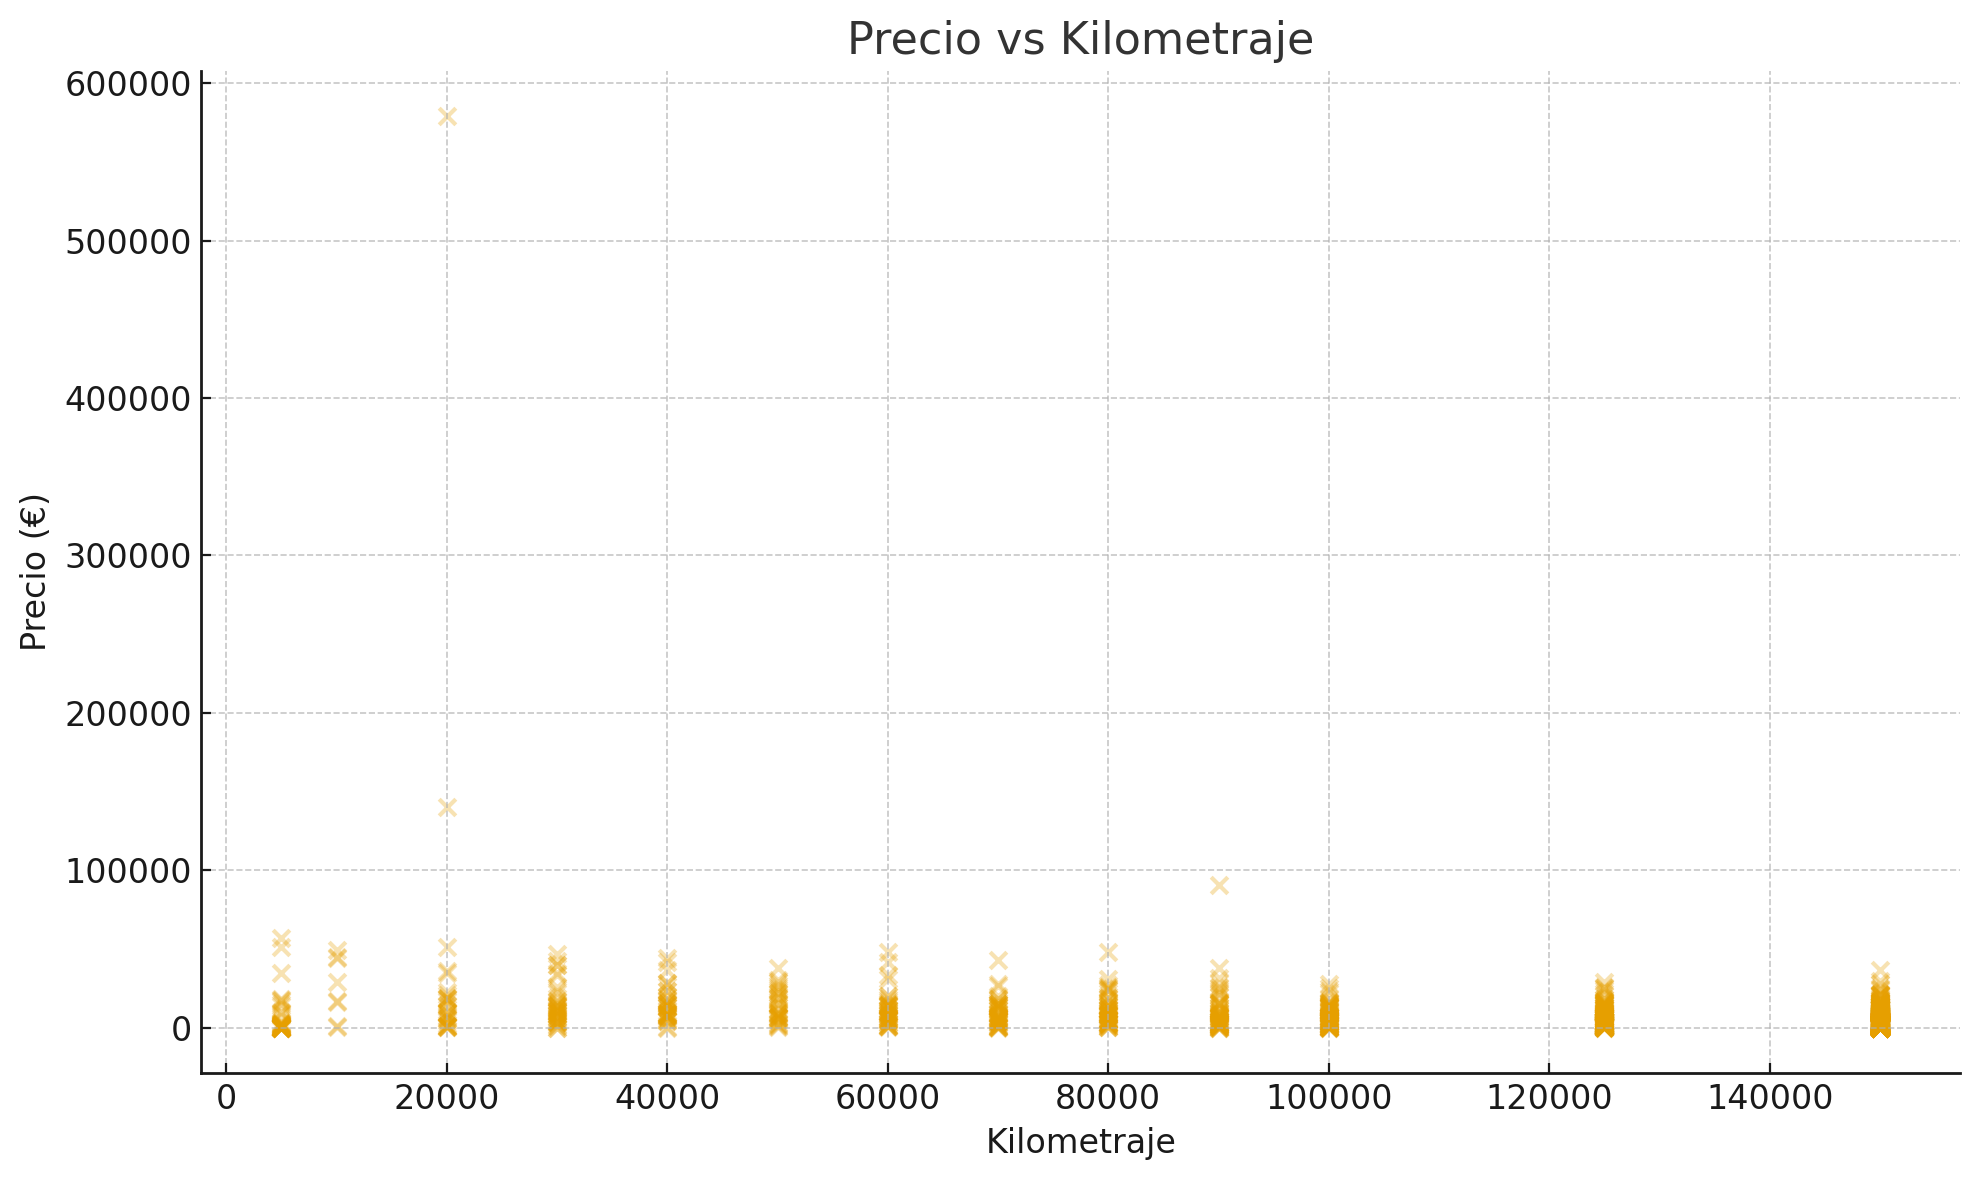

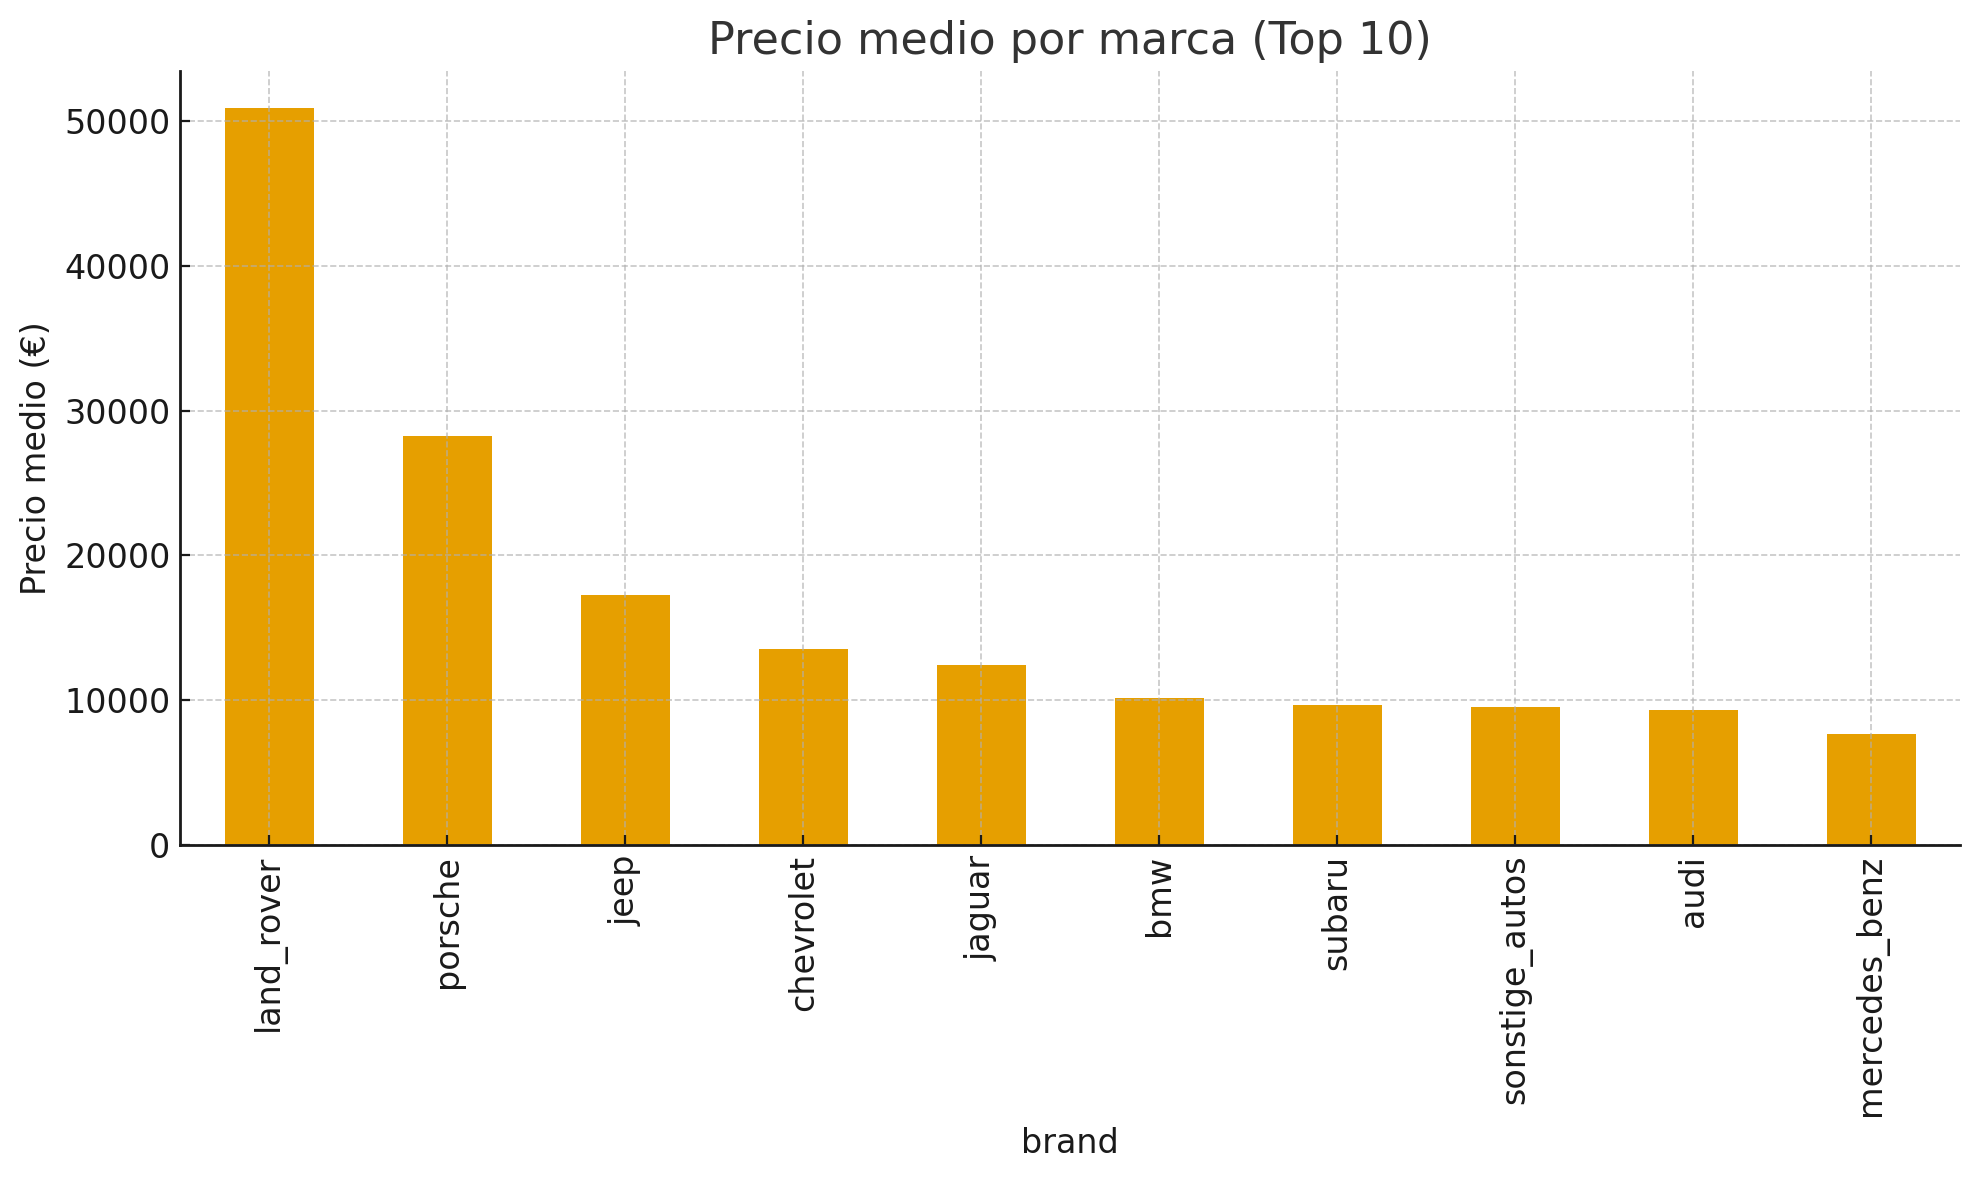

In [9]:
if set(["kilometer","price"]).issubset(df.columns):
    plt.figure()
    plt.scatter(df["kilometer"], df["price"], alpha=0.3)
    plt.title("Precio vs Kilometraje")
    plt.xlabel("Kilometraje"); plt.ylabel("Precio (€)")
    plt.tight_layout()
    plt.show()

if set(["brand","price"]).issubset(df.columns):
    plt.figure()
    df.groupby("brand")["price"].mean().sort_values(ascending=False).head(10).plot(kind="bar")
    plt.title("Precio medio por marca (Top 10)")
    plt.ylabel("Precio medio (€)")
    plt.tight_layout()
    plt.show()

**Interpretación (bivariadas):** Se observa tendencia decreciente de precio con mayor kilometraje y diferencias de precio medio entre marcas.

## Visualizaciones multivariadas (≥3 variables)

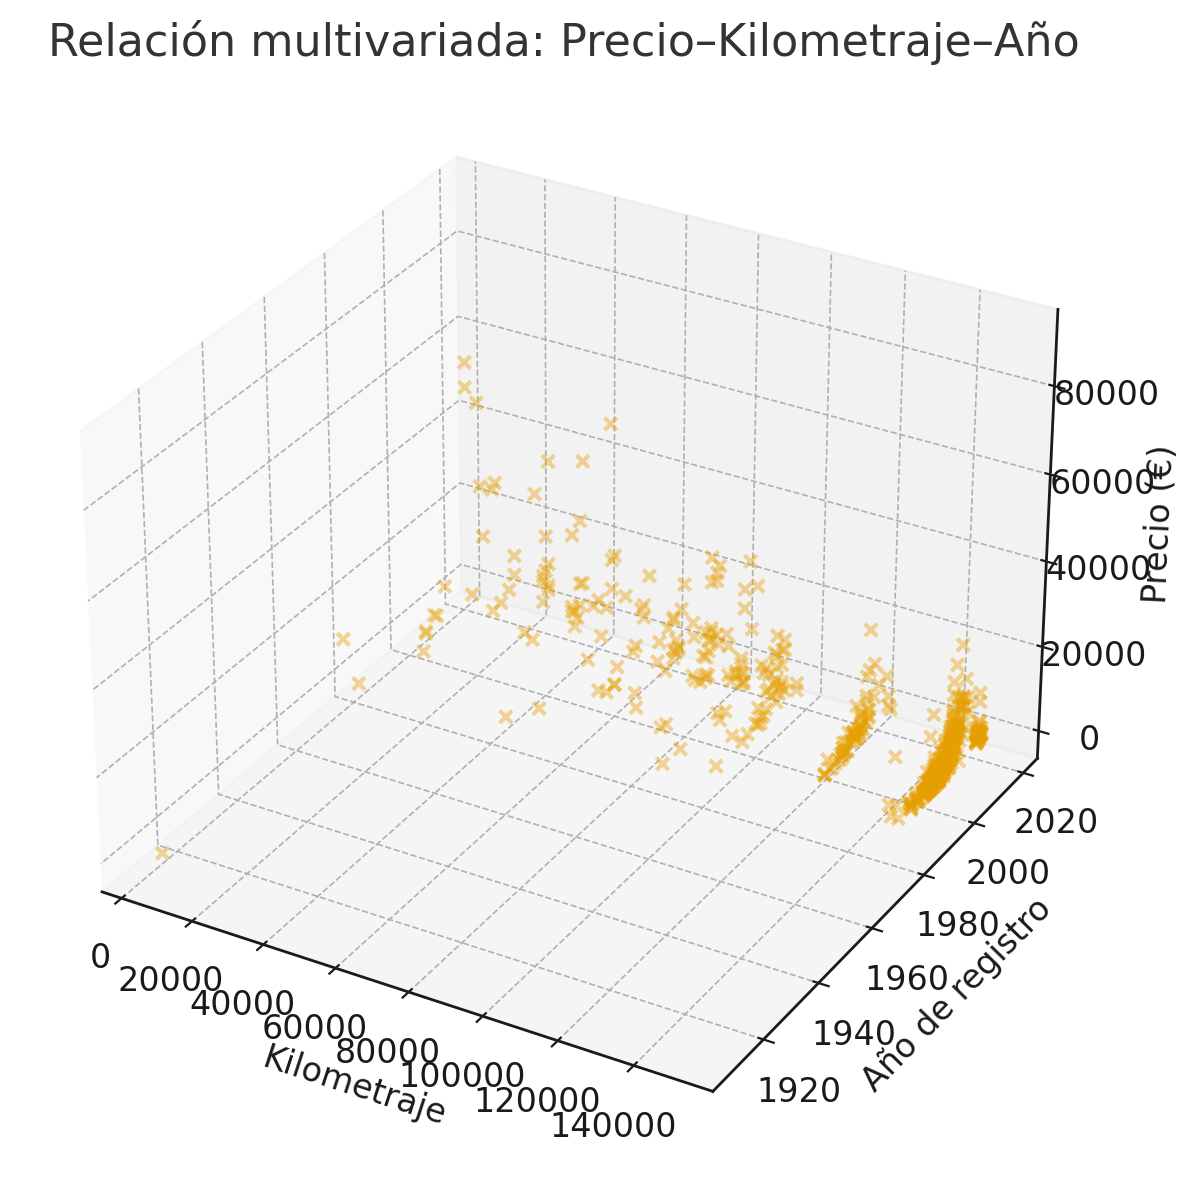

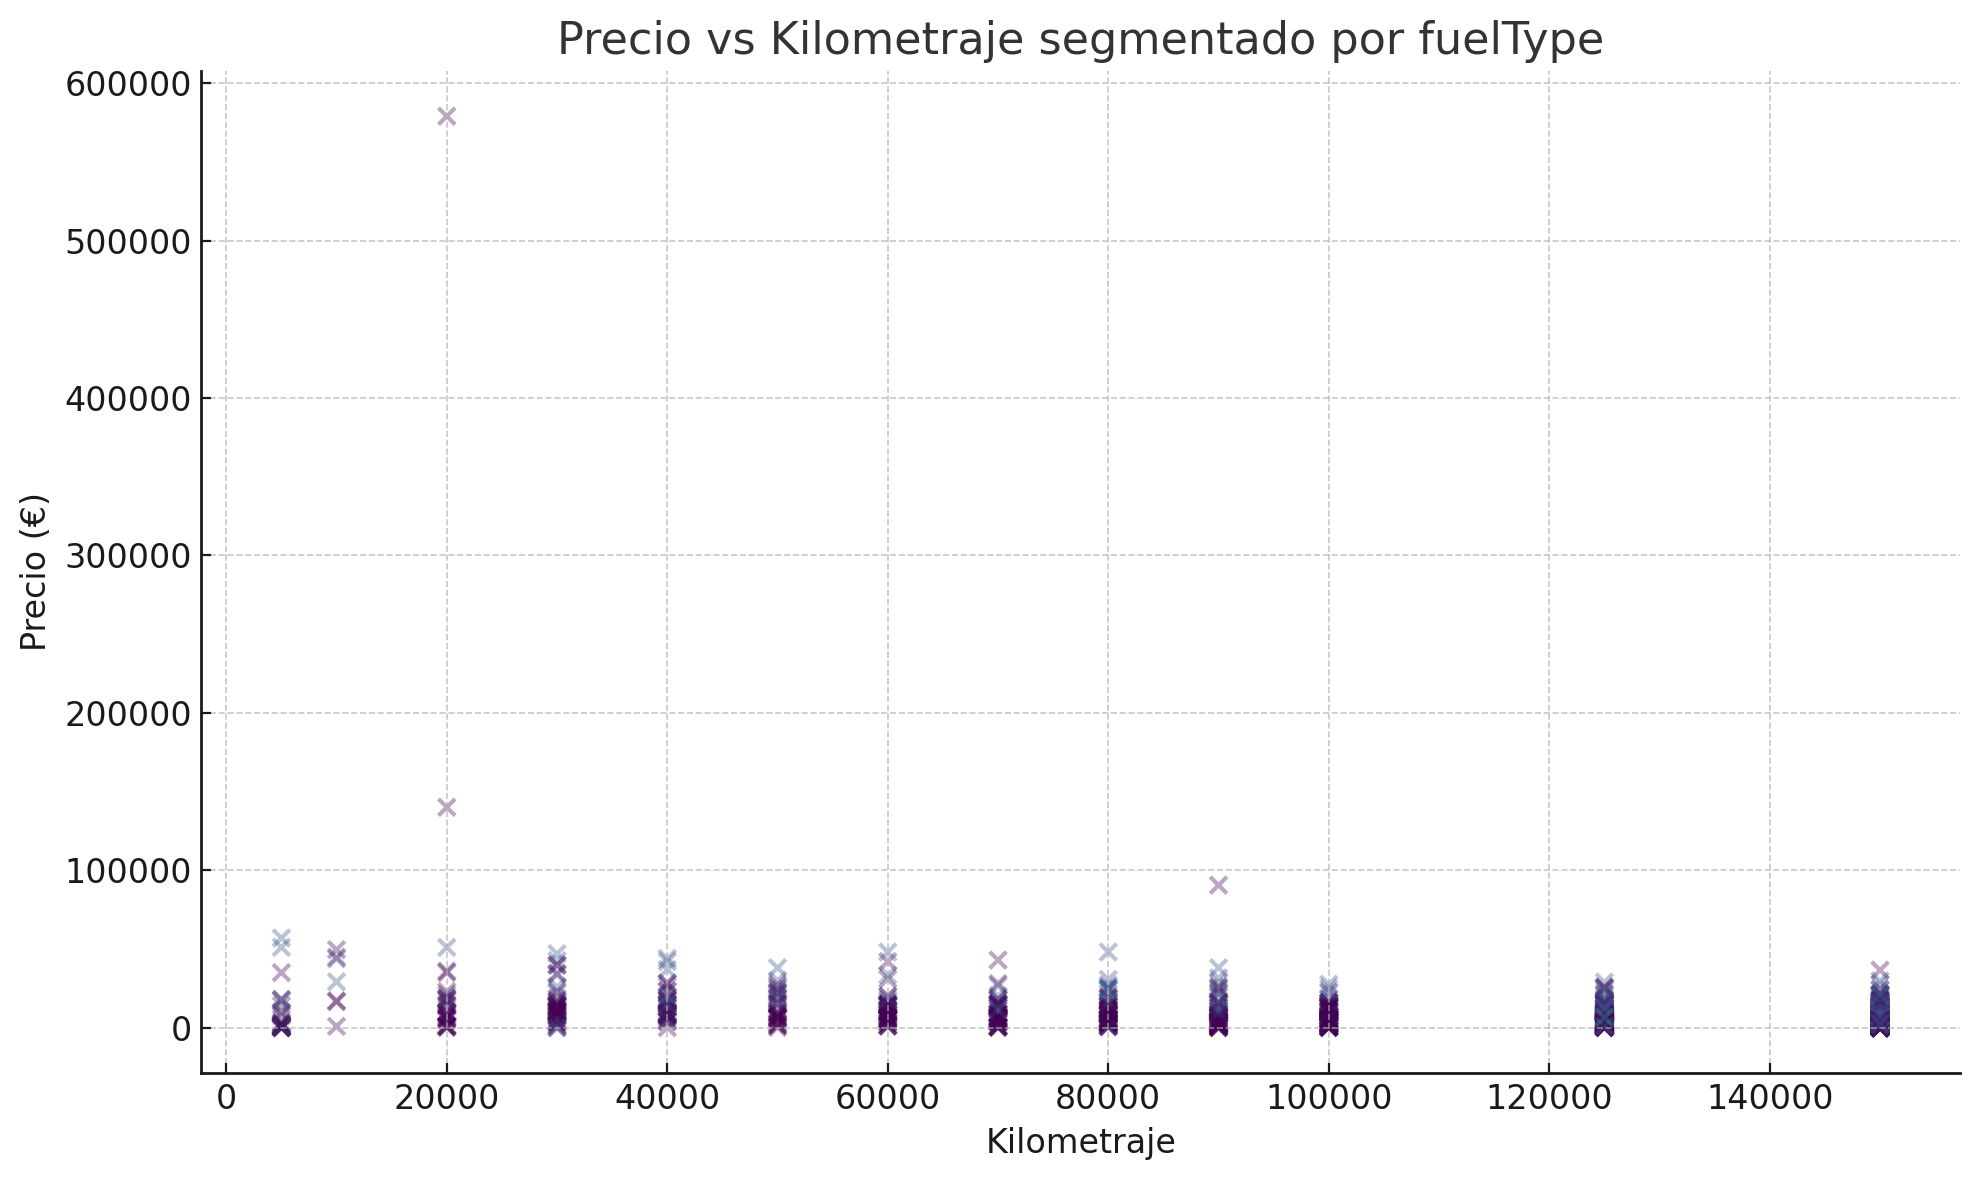

In [10]:
if set(["price","kilometer","yearOfRegistration"]).issubset(df.columns):
    sample = df.dropna(subset=["price","kilometer","yearOfRegistration"]).copy()
    if len(sample) > 600:
        sample = sample.sample(600, random_state=42)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(sample["kilometer"], sample["yearOfRegistration"], sample["price"], alpha=0.4)
    ax.set_xlabel("Kilometraje")
    ax.set_ylabel("Año de registro")
    ax.set_zlabel("Precio (€)")
    plt.title("Relación multivariada: Precio–Kilometraje–Año")
    plt.tight_layout()
    plt.show()

if set(["price","kilometer","fuelType"]).issubset(df.columns):
    sub = df.dropna(subset=["price","kilometer","fuelType"]).copy()
    if len(sub) > 2000:
        sub = sub.sample(2000, random_state=42)
    codes, uniques = pd.factorize(sub["fuelType"])
    plt.figure()
    plt.scatter(sub["kilometer"], sub["price"], c=codes, alpha=0.35)
    plt.title("Precio vs Kilometraje segmentado por fuelType")
    plt.xlabel("Kilometraje"); plt.ylabel("Precio (€)")
    plt.tight_layout()
    plt.show()

**Interpretación (multivariadas):** La proyección 3D refuerza depreciación con kilometraje y mayor valoración en años recientes; la segmentación por combustible sugiere diferencias entre grupos.

## Conclusiones y siguientes pasos

- **Hallazgos clave:** relación inversa entre precio y kilometraje; asociación positiva entre año y precio; diferencias por marca y combustible.
- **Hipótesis:** evidencia favorable para H1–H3 e indicios para H4–H5 (requiere curar valores de `notRepairedDamage`).
- **Limitaciones:** outliers en `price`, período acotado (mar–abr 2016), posibles inconsistencias de categorías.
- **Próximos pasos:** limpieza avanzada de outliers, normalización de categorías (`model`, `fuelType`), análisis geográfico con `postalCode` y modelado predictivo.

## Link video explicativo (opcional)
**Enlace:** _pendiente_ (agrega aquí tu URL de YouTube/Drive).

## Notas técnicas (criterios de calidad)
- Código probado con un subconjunto (2.000 filas) y preparado para escalar al dataset completo.
- Solo `pandas`, `numpy` y `matplotlib` (sin estilos externos).
- Comentarios y títulos/ejes claros; interpretaciones debajo de cada visualización.